# Chapter 5 基本的な回帰とモデルのチェック

## 5.1 重回帰

In [1]:
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/takashi_miyamoto/.pyenv/versions/anaconda3-2.1.0/lib/python3.4/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


ファイルからのデータの読み込み。同時に、`run-model5-3.R` で行った`Score`の正規化も実施。

In [2]:
df_1 = pd.read_csv('input/data-attendance-1.txt')
data_1 = df_1.to_dict('list')
data_1['N'] = len(df_1)
data_1['Score'] = [x/200 for x in data_1['Score']]
#data_1

図5.1のような図を作るのは大変だが、pandasのscatter_matrixは多少は近い図を出せる。

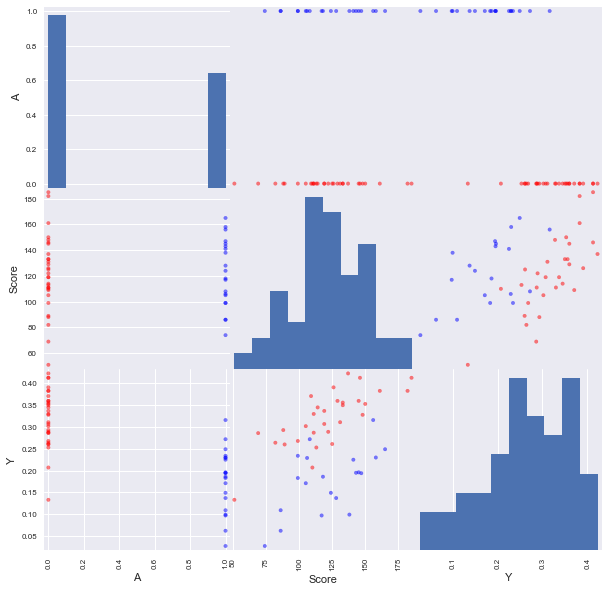

In [3]:
from pandas.tools.plotting import scatter_matrix
color=['red', 'blue']
scatter_matrix(df_1, figsize=(10, 10), \
    c=df_1['A'].apply(lambda x: color[x]), diagonal='hist');

モデル式5-3

$$ \begin{array}{ll}
\mu[n] = b_1 + b_2 A[n] + b_3 \text{Score}[n] & (n = 1, \cdots, N) \\
Y[n] \sim \text{Normal}(\mu[n], \sigma) & (n = 1, \cdots, N)
\end{array} $$

また、練習問題(2)の$\epsilon[n] = Y[n] - \mu[n]$ を算出するようにする。

In [4]:
model_5_3 = """
data {
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  real<lower=0, upper=1> Y[N];
}

parameters {
  real b1;
  real b2;
  real b3;
  real<lower=0> sigma;
}

transformed parameters {
  real mu[N];
  for (n in 1:N)
    mu[n] = b1 + b2*A[n] + b3*Score[n];
}

model {
  for (n in 1:N)
    Y[n] ~ normal(mu[n], sigma);
}

generated quantities {
  real y_pred[N];
  real e[N];
  for (n in 1:N) {
    y_pred[n] = normal_rng(mu[n], sigma);
    e[n] = Y[n] - mu[n];
  }
}
"""

In [5]:
fit1 = pystan.stan(model_code=model_5_3, data=data_1, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0016a71b87101220f13ade4050b102fc NOW.


In [6]:
print(fit1)

Inference for Stan model: anon_model_0016a71b87101220f13ade4050b102fc.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           0.12  1.3e-3   0.03   0.06    0.1   0.12   0.14   0.19    638   1.01
b2          -0.14  3.8e-4   0.01  -0.17  -0.15  -0.14  -0.13  -0.11   1508    1.0
b3           0.33  2.0e-3   0.05   0.22   0.29   0.33   0.36   0.43    664   1.01
sigma        0.05  1.7e-4 5.7e-3   0.04   0.05   0.05   0.06   0.06   1171    1.0
mu[0]        0.23  6.3e-4   0.02    0.2   0.22   0.24   0.25   0.27    686    1.0
mu[1]        0.22  3.3e-4   0.01   0.19   0.21   0.22   0.22   0.24   1491    1.0
mu[2]        0.33  2.4e-4 9.4e-3   0.31   0.32   0.33   0.33   0.34   1567    1.0
mu[3]        0.12  4.6e-4   0.01   0.09   0.11   0.12   0.13   0.15   1021    1.0
mu[4]        0.24  4.2e-4   0.01   0.21   0.23   0.24   0.25   0.26   1182 

In [7]:
df_1.head() # 長さ 50

,A,Score,Y
0,0,69,0.286
1,1,145,0.196
2,0,125,0.261
3,1,86,0.109
4,1,158,0.230


図5.3に近い図を出す

In [8]:
la = fit1.extract(permuted=True)
y_preds = la['y_pred'].T

In [9]:
df_1['y_10'] = [np.percentile(xs, 10.0) for xs in y_preds]
df_1['y_90'] = [np.percentile(xs, 90.0) for xs in y_preds]
df_1['mu'] = [np.average(xs) for xs in la['mu'].T]
df_1['errorbar'] = (df_1['y_90'] - df_1['y_10'])/2

In [10]:
df_1.head()

,A,Score,Y,y_10,y_90,mu,errorbar
0,0,69,0.286,0.164034,0.307132,0.234963,0.071549
1,1,145,0.196,0.146186,0.283976,0.215595,0.068895
2,0,125,0.261,0.260596,0.393839,0.326498,0.066622
3,1,86,0.109,0.051235,0.187089,0.119156,0.067927
4,1,158,0.230,0.163678,0.303991,0.236844,0.070156


In [11]:
df_1_0 = df_1[df_1['A']==0]
df_1_1 = df_1[df_1['A']==1]

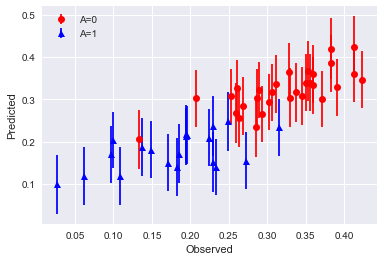

In [12]:
plt.errorbar(df_1_0['Y'], df_1_0['mu'], yerr=df_1_0['errorbar'], fmt="or", label='A=0')
plt.errorbar(df_1_1['Y'], df_1_1['mu'], yerr=df_1_1['errorbar'], fmt="^b", label='A=1')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(loc='upper left')
plt.show()

図5.3

練習問題(1) 相当のことをここで行っている

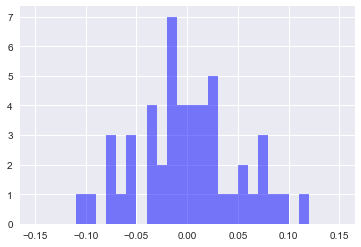

In [13]:
df_1['error'] = df_1['Y'] - df_1['mu']
plt.hist(df_1['error'], bins = 30, range = (-0.15, 0.15), \
         color='b', alpha=0.5);

練習問題(2)で計算した量をヒストグラムとして表示。上のヒストグラムと一致する。

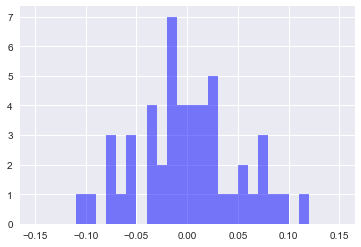

In [14]:
plt.hist([np.percentile(xs, 50.0) for xs in la['e'].T], \
    bins = 30, range = (-0.15, 0.15), color='b', alpha=0.5);

図5.5

相関係数の部分は諦めることにする

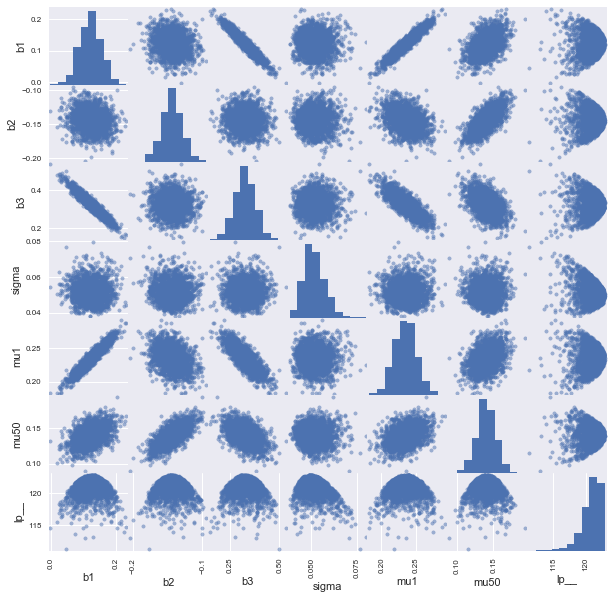

In [15]:
df_1a = pd.DataFrame(la['b1'], columns=['b1'])
df_1a['b2'] = la['b2']
df_1a['b3'] = la['b3']
df_1a['sigma'] = la['sigma']
df_1a['mu1'] = (la['mu'].T)[0]
df_1a['mu50'] = (la['mu'].T)[49]
df_1a['lp__'] = la['lp__']
#df_1a
scatter_matrix(df_1a, figsize=(10, 10), diagonal='hist');

## 5.2 二項ロジスチック回帰

図5.6と同じものを出すのは大変なので諦める

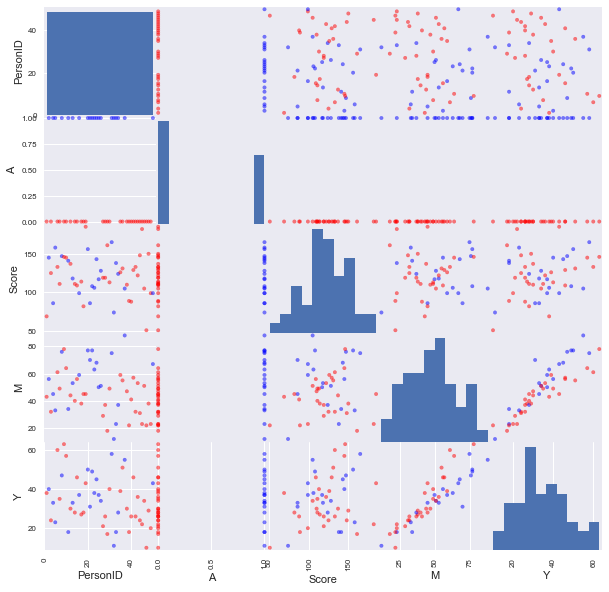

In [16]:
df_2 = pd.read_csv('input/data-attendance-2.txt')
data_2 = df_2.to_dict('list')
data_2['N'] = len(df_2)
data_2['Score'] = [x/200 for x in data_1['Score']]
color=['red', 'blue']
scatter_matrix(df_2, figsize=(10, 10), \
    c=df_2['A'].apply(lambda x: color[x]), diagonal='hist');

$$\begin{array}{ll}
q[n] = \text{inv_logit}(b_1 + b_2 A[n] + b_3 \text{Score}[n]) & n = 1, \cdots, N \\
Y[n] \sim \text{Binomial}(M[n], q[n]) & n = 1, \cdots, N
\end{array}$$

In [17]:
model_5_4 = """
data {
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  int<lower=0> M[N];
  int<lower=0> Y[N];
}

parameters {
  real b1;
  real b2;
  real b3;
}

transformed parameters {
  real q[N];
  for (n in 1:N)
    q[n] = inv_logit(b1 + b2*A[n] + b3*Score[n]);
}

model {
  for (n in 1:N)
    Y[n] ~ binomial(M[n], q[n]);
}

generated quantities {
  real y_pred[N];
  for (n in 1:N)
    y_pred[n] = binomial_rng(M[n], q[n]);
}
"""

In [18]:
fit2 = pystan.stan(model_code=model_5_4, data=data_2, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6c0d312199fd1bf03bd69a462fdc1e79 NOW.


`fit`の出力結果は、$b_3$ の値がテキストと200倍異なる。モデルの方で`Score`は$200$で割ることで$0 \sim 1$の値に制限しているため、$b_3$の値が$200$倍になっている。

In [19]:
print(fit2)

Inference for Stan model: anon_model_6c0d312199fd1bf03bd69a462fdc1e79.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1            0.1  8.6e-3   0.23  -0.32  -0.06    0.1   0.24   0.56    694   1.01
b2          -0.62  2.9e-3   0.09  -0.81  -0.69  -0.62  -0.56  -0.45   1030    1.0
b3         378.54     2.6  72.05 230.39 329.38 379.96 428.41 516.13    769   1.01
q[0]         0.68  9.1e-4   0.02   0.63   0.66   0.68    0.7   0.73    744   1.01
q[1]          0.7  5.2e-4   0.02   0.67   0.69    0.7   0.71   0.73    940    1.0
q[2]         0.78  3.0e-4   0.01   0.76   0.78   0.78   0.79    0.8   1430    1.0
q[3]         0.57  7.1e-4   0.02   0.53   0.56   0.57   0.59   0.61    944    1.0
q[4]         0.73  6.3e-4   0.02   0.69   0.71   0.73   0.74   0.76    832   1.01
q[5]          0.8  3.1e-4   0.01   0.77   0.79    0.8    0.8   0.82   1427 

図5.8

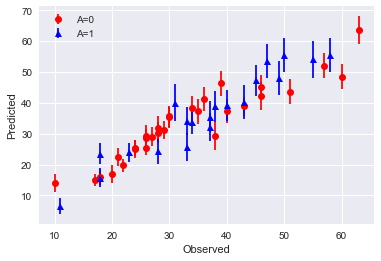

In [20]:
la = fit2.extract(permuted=True)
y_preds = la['y_pred'].T
df_2['y_10'] = [np.percentile(xs, 10.0) for xs in y_preds]
df_2['y_90'] = [np.percentile(xs, 90.0) for xs in y_preds]
df_2['q'] = [np.average(xs) for xs in la['q'].T]
df_2['mu'] = df_2['q']*df_2['M']
df_2['errorbar'] = (df_2['y_90'] - df_2['y_10'])/2
df_2_0 = df_2[df_2['A']==0]
df_2_1 = df_2[df_2['A']==1]
plt.errorbar(df_2_0['Y'], df_2_0['mu'], yerr=df_2_0['errorbar'], fmt="or", label='A=0')
plt.errorbar(df_2_1['Y'], df_2_1['mu'], yerr=df_2_1['errorbar'], fmt="^b", label='A=1')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(loc='upper left')
plt.show()

## 5.3 ロジスチック回帰

In [21]:
df_3 = pd.read_csv('input/data-attendance-3.txt')
conv = {'A':0.0, 'B':0.2, 'C':1.0}
df_3['W'] = [conv[x] for x in df_3['Weather']]
df_3['Score'] = [x/200 for x in df_3['Score']]
df_3.head()

,PersonID,A,Score,Weather,Y,W
0,1,0,0.345,B,1,0.2
1,1,0,0.345,A,1,0.0
2,1,0,0.345,C,1,1.0
3,1,0,0.345,A,1,0.0
4,1,0,0.345,B,1,0.2


5.3.2 のような集計処理。二次元の表では無いが、こんな感じには集計できる。

In [22]:
df_3.groupby(['Y', 'Weather']).count()

PersonID    A  Score    W
Y Weather                           
0 A             306  306    306  306
  B             230  230    230  230
  C             138  138    138  138
1 A             953  953    953  953
  B             500  500    500  500
  C             269  269    269  269

練習問題(3) `Y` と `A` で集計

In [23]:
df_3.groupby(['Y', 'A']).count()

PersonID  Score  Weather    W
Y A                               
0 0       288    288      288  288
  1       386    386      386  386
1 0       994    994      994  994
  1       728    728      728  728

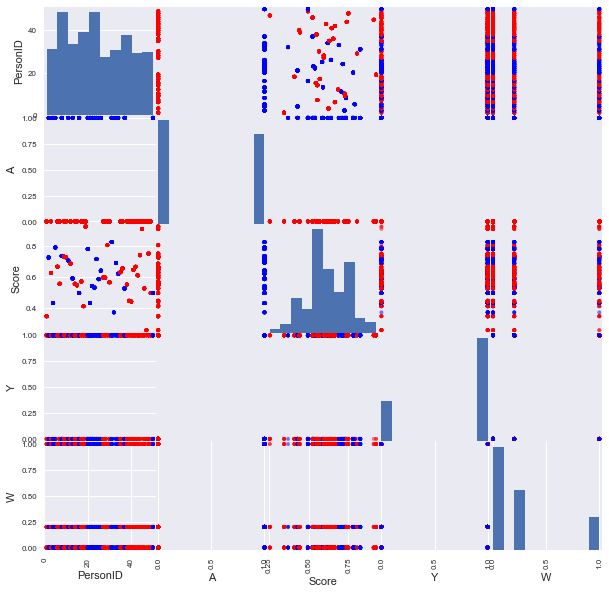

In [24]:
color=['red', 'blue']
scatter_matrix(df_3, figsize=(10, 10), \
    c=df_3['A'].apply(lambda x: color[x]), diagonal='hist');

In [25]:
data_3 = df_3.to_dict('list')
data_3['I'] = len(df_3)
del data_3['Weather']

In [26]:
model_5_5 = """
data {
  int I;
  int<lower=0, upper=1> A[I];
  real<lower=0, upper=1> Score[I];
  real<lower=0, upper=1> W[I];
  int<lower=0, upper=1> Y[I];
}

parameters {
  real b[4];
}

transformed parameters {
  real q[I];
  for (i in 1:I)
    q[i] = inv_logit(b[1] + b[2]*A[i] + b[3]*Score[i] + b[4]*W[i]);
}

model {
  for (i in 1:I)
    Y[i] ~ bernoulli(q[i]);
}
"""

In [27]:
fit3 = pystan.stan(model_code=model_5_5, data=data_3, iter=1000, chains=4)
print(fit3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_830c1bb02a09129b9776f98ffa73b143 NOW.


Inference for Stan model: anon_model_830c1bb02a09129b9776f98ffa73b143.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]      0.18  8.7e-3   0.23  -0.25   0.02   0.18   0.33   0.64    709   1.01
b[1]     -0.62  2.7e-3    0.1  -0.82  -0.69  -0.62  -0.56  -0.43   1242    1.0
b[2]      1.95    0.01   0.36   1.21   1.72   1.95   2.19   2.66    754   1.01
b[3]     -0.47  3.6e-3   0.12  -0.71  -0.55  -0.47  -0.38  -0.23   1157    1.0
q[0]      0.68  9.3e-4   0.03   0.63   0.66   0.68    0.7   0.73    747   1.01
q[1]       0.7  9.3e-4   0.03   0.65   0.68    0.7   0.72   0.75    740   1.01
q[2]      0.59  1.2e-3   0.04   0.52   0.57   0.59   0.62   0.66    875    1.0
q[3]       0.7  9.3e-4   0.03   0.65   0.68    0.7   0.72   0.75    740   1.01
q[4]      0.68  9.3e-4   0.03   0.63   0.66   0.68    0.7   0.73    747   1.01
q[5]      0.68  9.3e-4 

In [28]:
la = fit3.extract(permuted=True)
df_3a = pd.DataFrame([np.percentile(xs, 50.0) for xs in la['q'].T], \
    columns=['q'])
df_3a['A'] = df_3['A']
df_3a['Y'] = df_3['Y']
df_3a.head()

,q,A,Y
0,0.680358,0,1
1,0.700457,0,1
2,0.594981,0,1
3,0.700457,0,1
4,0.680358,0,1


図5.10に近いものを出してみようとしたもの

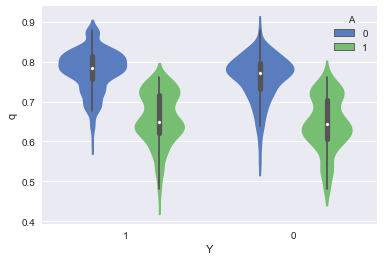

In [29]:
sns.violinplot(x="Y", y="q", hue="A", \
    data=df_3a, palette="muted")

練習問題(4)

モデルの変更点

* 曇り(B)ならば $1$、さもなければ $0$ という変数 `B[I]`
* 雨(C)ならば $1$、さもなければ $0$ という変数 `C[I]`
* `b[4]`は曇りの、`b[5]`は雨の際の重み変数とする

$$q[i] = \text{inv_logit}(b_1 + b_2*A[i] + b_3*\text{Score}[i] + 
  b_4*B[i] + b_5 * C[i])$$


In [30]:
model_5_5e = """
data {
  int I;
  int<lower=0, upper=1> A[I];
  real<lower=0, upper=1> Score[I];
  int<lower=0, upper=1> B[I];
  int<lower=0, upper=1> C[I];
  int<lower=0, upper=1> Y[I];
}

parameters {
  real b[5];
}

transformed parameters {
  real q[I];
  for (i in 1:I)
    q[i] = inv_logit(b[1] + b[2]*A[i] + b[3]*Score[i] + b[4]*B[i] + b[5]*C[i]);
}

model {
  for (i in 1:I)
    Y[i] ~ bernoulli(q[i]);
}
"""

In [31]:
df_3e = pd.read_csv('input/data-attendance-3.txt')
df_3e.head()

,PersonID,A,Score,Weather,Y
0,1,0,69,B,1
1,1,0,69,A,1
2,1,0,69,C,1
3,1,0,69,A,1
4,1,0,69,B,1


In [32]:
df_3e['B'] = [(1 if x == 'B' else 0) for x in df_3e['Weather']]
df_3e['C'] = [(1 if x == 'C' else 0) for x in df_3e['Weather']]
df_3e['Score'] = [x/200 for x in df_3e['Score']]
df_3e.head()

,PersonID,A,Score,Weather,Y,B,C
0,1,0,0.345,B,1,1,0
1,1,0,0.345,A,1,0,0
2,1,0,0.345,C,1,0,1
3,1,0,0.345,A,1,0,0
4,1,0,0.345,B,1,1,0


In [33]:
data_3e = df_3e.to_dict('list')
data_3e['I'] = len(df_3e)
del data_3e['Weather']

In [34]:
fit3e = pystan.stan(model_code=model_5_5e, data=data_3e, iter=1000, chains=4)
print(fit3e)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_33f40a036311df63c6b1edc975880a35 NOW.


Inference for Stan model: anon_model_33f40a036311df63c6b1edc975880a35.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]      0.26  6.6e-3   0.22  -0.16   0.11   0.26   0.41   0.72   1104    1.0
b[1]     -0.63  2.5e-3    0.1  -0.82   -0.7  -0.63  -0.56  -0.45   1531    1.0
b[2]      1.97    0.01   0.36   1.24   1.75   1.97   2.22   2.66   1134    1.0
b[3]     -0.38  2.7e-3   0.11  -0.59  -0.45  -0.38  -0.31  -0.17   1556    1.0
b[4]     -0.49  3.3e-3   0.13  -0.75  -0.58  -0.49  -0.41  -0.24   1519    1.0
q[0]      0.64  8.0e-4   0.03   0.58   0.62   0.64   0.66   0.69   1411    1.0
q[1]      0.72  6.9e-4   0.02   0.67    0.7   0.72   0.74   0.76   1162    1.0
q[2]      0.61  9.4e-4   0.04   0.54   0.59   0.61   0.63   0.68   1444    1.0
q[3]      0.72  6.9e-4   0.02   0.67    0.7   0.72   0.74   0.76   1162    1.0
q[4]      0.64  8.0e-4 

In [35]:
la = fit3e.extract(permuted=True)
df_3ae = pd.DataFrame([np.percentile(xs, 50.0) for xs in la['q'].T], \
    columns=['q'])
df_3ae['A'] = df_3e['A']
df_3ae['Y'] = df_3e['Y']
df_3ae.head()

,q,A,Y
0,0.637494,0,1
1,0.720356,0,1
2,0.610272,0,1
3,0.720356,0,1
4,0.637494,0,1


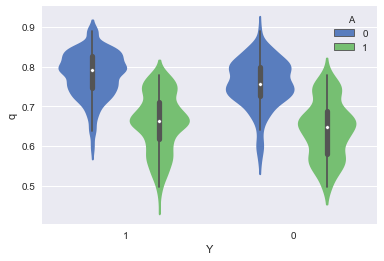

In [36]:
sns.violinplot(x="Y", y="q", hue="A", \
    data=df_3ae, palette="muted")

## 5.4 ポアソン回帰

$$\begin{array}{ll}
A[n] = \exp(b_1 + b_2*A[n] + b_3 \text{Score}[n]) & n = 1, \cdots, N \\
M[n] \sim \text{Poisson}(A[n]) & n = 1, \cdots, N
\end{array}$$

In [37]:
model_5_6 = """
data {
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  int<lower=0> M[N];
}

parameters {
  real b[3];
}

transformed parameters {
  real lambda[N];
  for (n in 1:N)
    lambda[n] = b[1] + b[2]*A[n] + b[3]*Score[n];
}

model {
  for (n in 1:N)
    M[n] ~ poisson_log(lambda[n]);
}

generated quantities {
  int m_pred[N];
  for (n in 1:N)
    m_pred[n] = poisson_log_rng(lambda[n]);
}
"""

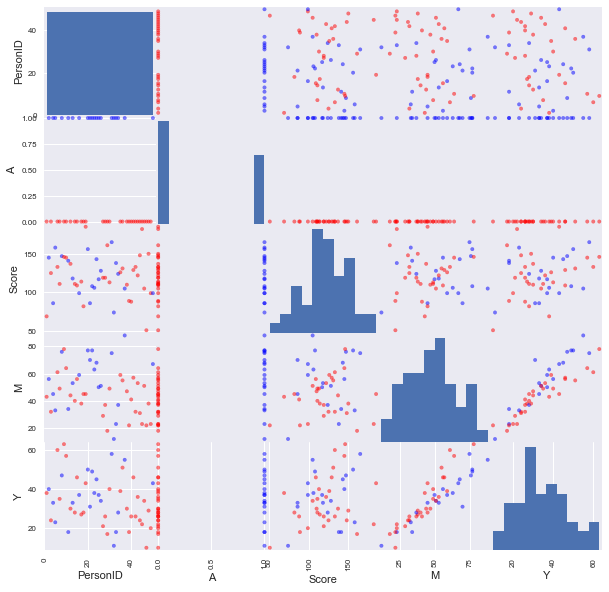

In [38]:
df_4 = pd.read_csv('input/data-attendance-2.txt')
data_4 = df_4.to_dict('list')
data_4['N'] = len(df_4)
data_4['Score'] = [x/200 for x in data_4['Score']]
color=['red', 'blue']
scatter_matrix(df_4, figsize=(10, 10), \
    c=df_2['A'].apply(lambda x: color[x]), diagonal='hist');

In [39]:
del data_4['Y']

In [40]:
fit4 = pystan.stan(model_code=model_5_6, data=data_4, iter=1000, chains=4)
print(fit4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c52748b6870341a4d0071ae22131e555 NOW.


Inference for Stan model: anon_model_c52748b6870341a4d0071ae22131e555.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]         3.58  4.1e-3    0.1   3.37   3.51   3.58   3.65   3.77    616    1.0
b[1]         0.27  1.6e-3   0.04   0.18   0.24   0.26   0.29   0.35    693    1.0
b[2]         0.28  6.1e-3   0.16  -0.03   0.17   0.28   0.39   0.61    677    1.0
lambda[0]    3.68  2.1e-3   0.05   3.58   3.65   3.68   3.71   3.77    596    1.0
lambda[1]    4.05  1.2e-3   0.03   3.99   4.03   4.05   4.07   4.12    875    1.0
lambda[2]    3.76  8.1e-4   0.03    3.7   3.74   3.76   3.78   3.81   1214    1.0
lambda[3]    3.97  1.3e-3   0.04   3.88   3.94   3.97    4.0   4.04   1013    1.0
lambda[4]    4.07  1.5e-3   0.04   3.99   4.04   4.07    4.1   4.15    763    1.0
lambda[5]    3.77  7.9e-4   0.03   3.71   3.75   3.77   3.79   3.83   1380 

練習問題(5)

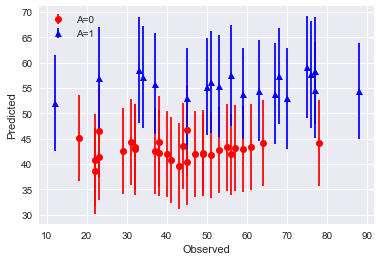

In [41]:
df_4e = pd.read_csv('input/data-attendance-2.txt')
la = fit4.extract(permuted=True)
m_preds = la['m_pred'].T
df_4e['m_10'] = [np.percentile(xs, 10.0) for xs in m_preds]
df_4e['m_90'] = [np.percentile(xs, 90.0) for xs in m_preds]
df_4e['lam'] = [np.exp(np.average(xs)) for xs in la['lambda'].T]
df_4e['errorbar'] = (df_4e['m_90'] - df_4e['m_10'])/2
df_4e_0 = df_4e[df_4e['A']==0]
df_4e_1 = df_4e[df_4e['A']==1]
plt.errorbar(df_4e_0['M'], df_4e_0['lam'], yerr=df_4e_0['errorbar'], fmt="or", label='A=0')
plt.errorbar(df_4e_1['M'], df_4e_1['lam'], yerr=df_4e_1['errorbar'], fmt="^b", label='A=1')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(loc='upper left')
plt.show()

練習問題(6)

In [42]:
df_ex6 = pd.read_csv('input/data3a.csv')
df_ex6['f'] = [(1 if x == 'T' else 0) for x in df_ex6['f']]
data_ex6 = df_ex6.to_dict('list')
data_ex6['N'] = len(df_ex6)
df_ex6.head()

,y,x,f
0,6,8.31,0
1,6,9.44,0
2,6,9.50,0
3,12,9.07,0
4,10,10.16,0


初期値を適当に与えてやらないと`poisson_log`の引数範囲を溢れるので、グラフを書いて良さげなパラメータ範囲を決める必要があった

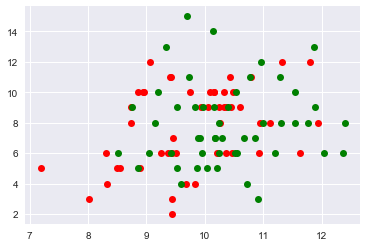

In [43]:
df_ex6_0 = df_ex6[df_ex6['f'] == 0]
df_ex6_1 = df_ex6[df_ex6['f'] == 1]
plt.plot(df_ex6_0['x'], df_ex6_0['y'], 'ro')
plt.plot(df_ex6_1['x'], df_ex6_1['y'], 'go')
plt.show()

In [44]:
model_ex6 = """
data {
  int N;
  real x[N];
  int<lower=0, upper=1> f[N];
  int<lower=0> y[N];
}

parameters {
  real<lower=0, upper=1> b1;
  real<lower=-1, upper=1> b2;
  real<lower=-2, upper=2> b3;
}

transformed parameters {
  real lambda[N];
  for (n in 1:N)
    lambda[n] = b1*x[n] + b2*f[n] + b3;
}

model {
  for (n in 1:N)
    y[n] ~ poisson_log(lambda[n]);
}

generated quantities {
  int y_pred[N];
  for (n in 1:N)
    y_pred[n] = poisson_log_rng(lambda[n]);
}
"""

In [45]:
fit6 = pystan.stan(model_code=model_ex6, data=data_ex6, iter=1000, chains=4)
print(fit6)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_51d348d8b8505ae9630de2fe9c58f829 NOW.


Inference for Stan model: anon_model_51d348d8b8505ae9630de2fe9c58f829.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           0.09  2.3e-3   0.03   0.02   0.06   0.08   0.11   0.15    203   1.02
b2          -0.04  2.8e-3   0.07  -0.17  -0.08  -0.03 8.4e-3    0.1    587   1.01
b3           1.21    0.02   0.34   0.54    1.0   1.22   1.46   1.82    198   1.02
lambda[0]    1.92  5.1e-3   0.07   1.77   1.87   1.92   1.97   2.06    207   1.02
lambda[1]    2.02  2.2e-3   0.05   1.91   1.98   2.02   2.05   2.12    561   1.01
lambda[2]    2.02  2.1e-3   0.05   1.92   1.99   2.02   2.06   2.12    589   1.01
lambda[3]    1.98  3.5e-3   0.06   1.87   1.95   1.98   2.02   2.09    266   1.01
lambda[4]    2.08  1.7e-3   0.05   1.98   2.04   2.08   2.11   2.18    892   1.01
lambda[5]    1.92  5.1e-3   0.07   1.77   1.87   1.92   1.97   2.06    208 

Observedは整数値だが、それだとプロットする点が重なって表現しづらいので、$\pm 0.2$の範囲に一様に散らして表現することにする

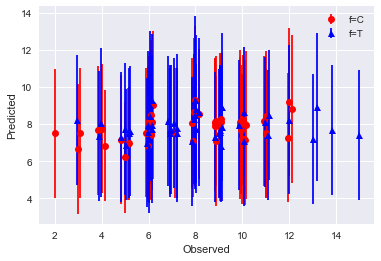

In [46]:
la = fit6.extract(permuted=True)
y_preds = la['y_pred'].T
df_ex6['y_10'] = [np.percentile(xs, 10.0) for xs in y_preds]
df_ex6['y_90'] = [np.percentile(xs, 90.0) for xs in y_preds]
df_ex6['lam'] = [np.exp(np.average(xs)) for xs in la['lambda'].T]
df_ex6['errorbar'] = (df_ex6['y_90'] - df_ex6['y_10'])/2
df_ex6_0 = df_ex6[df_ex6['f']==0]
df_ex6_1 = df_ex6[df_ex6['f']==1]
plt.errorbar(df_ex6_0['y']+(np.random.random(len(df_ex6_0))-0.5)/2.5, df_ex6_0['lam'], yerr=df_ex6_0['errorbar'], fmt="or", label='f=C')
plt.errorbar(df_ex6_1['y']+(np.random.random(len(df_ex6_1))-0.5)/2.5, df_ex6_1['lam'], yerr=df_ex6_1['errorbar'], fmt="^b", label='f=T')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.show()

練習問題(7)

In [47]:
df_ex7 = pd.read_csv('input/data4a.csv')
df_ex7['f'] = [(1 if x == 'T' else 0) for x in df_ex7['f']]
data_ex7 = df_ex7.to_dict('list')
data_ex7['M'] = len(df_ex7)
df_ex7.head()

,N,y,x,f
0,8,1,9.76,0
1,8,6,10.48,0
2,8,5,10.83,0
3,8,6,10.94,0
4,8,1,9.37,0


In [48]:
model_ex7 = """
data {
  int M;
  int<lower=0> N[M];
  int<lower=0> y[M];
  real<lower=0> x[M];
  int<lower=0, upper=1> f[M];
}

parameters {
  real b1;
  real b2;
  real b3;
}

transformed parameters {
  real q[M];
  for (m in 1:M)
    q[m] = inv_logit(b1 + b2*x[m] + b3*f[m]);
}

model {
  for (m in 1:M)
    y[m] ~ binomial(N[m], q[m]);
}

generated quantities {
  real y_pred[M];
  for (m in 1:M)
    y_pred[m] = binomial_rng(N[m], q[m]);
}
"""

In [49]:
fit7 = pystan.stan(model_code=model_ex7, data=data_ex7, iter=1000, chains=4)
print(fit7)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5129b07458e34ff3e2d97065d096286f NOW.


Inference for Stan model: anon_model_5129b07458e34ff3e2d97065d096286f.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1         -19.63    0.06   1.31 -22.36 -20.46 -19.61 -18.75 -17.14    502   1.01
b2           1.96  5.7e-3   0.13   1.72   1.88   1.96   2.04   2.23    502   1.01
b3           2.03  8.5e-3   0.22   1.59   1.87   2.03   2.18   2.47    693    1.0
q[0]         0.38  9.9e-4   0.03   0.32   0.36   0.38    0.4   0.45   1071    1.0
q[1]         0.72  7.9e-4   0.03   0.66    0.7   0.72   0.73   0.77   1284    1.0
q[2]         0.83  6.9e-4   0.02   0.79   0.82   0.83   0.85   0.87   1049   1.01
q[3]         0.86  6.4e-4   0.02   0.82   0.85   0.86   0.87    0.9    983   1.01
q[4]         0.22  9.8e-4   0.03   0.17    0.2   0.22   0.24   0.28    817    1.0
q[5]         0.09  6.7e-4   0.02   0.06   0.08   0.09    0.1   0.13    655 

Observedは整数値だが、それだとプロットする点が重なって表現しづらいので、$\pm 0.2$の範囲に一様に散らして表現することにする

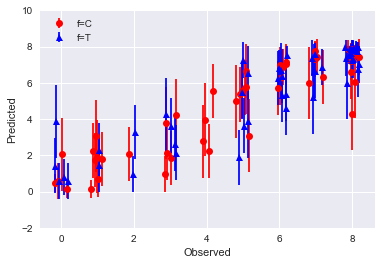

In [50]:
la = fit7.extract(permuted=True)
y_preds = la['y_pred'].T
df_ex7['y_10'] = [np.percentile(xs, 10.0) for xs in y_preds]
df_ex7['y_90'] = [np.percentile(xs, 90.0) for xs in y_preds]
df_ex7['lam'] = [q*N for (q,N) in zip( \
    [np.average(xs) for xs in la['q'].T], df_ex7['N'])]
df_ex7['errorbar'] = (df_ex7['y_90'] - df_ex7['y_10'])/2
df_ex7_0 = df_ex7[df_ex7['f']==0]
df_ex7_1 = df_ex7[df_ex7['f']==1]
plt.errorbar(df_ex7_0['y']+(np.random.random(len(df_ex7_0))-0.5)/2.5, df_ex7_0['lam'], yerr=df_ex7_0['errorbar'], fmt="or", label='f=C')
plt.errorbar(df_ex7_1['y']+(np.random.random(len(df_ex7_1))-0.5)/2.5, df_ex7_1['lam'], yerr=df_ex7_1['errorbar'], fmt="^b", label='f=T')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(loc='upper left')
plt.ylim(-2, 10)
plt.show()